In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

In [2]:
def prims_algorithm(graph):
    N = len(graph)
    inf = float('inf')
    selected_node = np.zeros(N)
    mst = np.zeros((N - 1, 3), dtype=np.uint64)
    no_edge = 0
    selected_node[0] = True
    while(no_edge < N - 1):
        minimum = inf
        x = 0
        y = 0
        for i in range(N):
            if selected_node[i]:
                for j in range(N):
                    if ((not selected_node[j]) and graph[i][j]):
                        if minimum > graph[i][j]:
                            minimum = graph[i][j]
                            x = i
                            y = j
        mst[no_edge, 0], mst[no_edge, 1], mst[no_edge, 2] = x, y, graph[x][y]
        selected_node[y] = True
        no_edge += 1
    return mst

In [3]:
def kruskalMST(cost):
    return None

In [4]:
def random_symmetric_matrix(n: int, item_range=(0, 100)):
    random_matrix = np.random.randint(item_range[0], item_range[1], (n, n), dtype=np.uint8)
    return (random_matrix + random_matrix.T) // 2

In [5]:
def draw_chart(x, y, z, title):
    plt.style.use('_mpl-gallery')

    sorted_args = np.argsort(x)
    x = x[sorted_args]
    y = y[sorted_args]
    z = z[sorted_args]

    fig, ax = plt.subplots(figsize=(18, 4))
    
    ax.plot(x, y, linewidth=2.0, color='green', label='Prim Algorithm')
    ax.plot(x, z, linewidth=2.0, color='red', label='Kruskal Algorithm')

    ax.legend()
    plt.title(title)
    
    plt.show()

In [6]:
def benchmark(repetitions_count, matrix_size_range = (0, 200)):
    prim_elapsed_times = np.zeros(repetitions_count)
    kruskal_elapsed_times = np.zeros(repetitions_count)
    graph_sizes = np.zeros(repetitions_count, dtype=np.int16)
    
    for i in range(repetitions_count):

        # generate random complete graph
        size = np.random.randint(matrix_size_range[0], matrix_size_range[1], dtype=np.int16)
        M = random_symmetric_matrix(size, (1,100))
        graph_sizes[i] = size
    
        # running prim algorithm for complete graph
        start_time = time.time()
        p = prims_algorithm(M)
        end_time = time.time()
        elapsed_time = end_time - start_time
        prim_elapsed_times[i] = elapsed_time
    
        # running kruskal algorithm for complete graph
        start_time = time.time()
        p = kruskalMST(M)
        end_time = time.time()
        elapsed_time = end_time - start_time
        kruskal_elapsed_times[i] = elapsed_time

    return graph_sizes, prim_elapsed_times, kruskal_elapsed_times

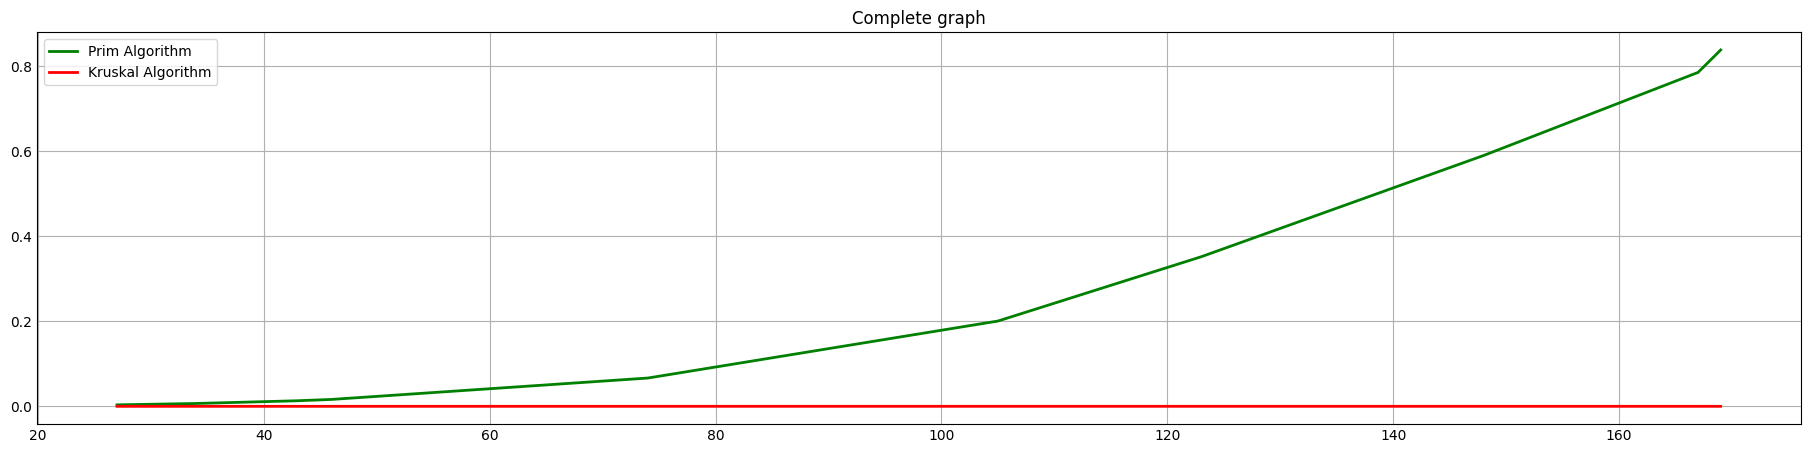

In [9]:
nodes_count, prim_times, kruskal_times = benchmark(10)
draw_chart(nodes_count, prim_times, kruskal_times, "Complete graph")